# Import

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import keras
import cv2
from keras import layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import sys
# temp = sys.stdout
# sys.stdout = f = open('log.txt', 'w')

# Variable

In [2]:
train_dir = 'train2'
val_dir = 'valid2'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 5
classes = ['ABBOTTS BOOBY', 'AMERICAN COOT', 'BEARDED REEDLING', 'BLACK SKIMMER', 'COCKATOO', 'CROW', 'EASTERN BLUEBIRD', 'FLAMINGO', 'GOLDEN EAGLE', 'GREAT GRAY OWL']

# Image Data Generator

In [3]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = IMAGE_SIZE
)

val_data=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode = 'categorical',
    image_size = IMAGE_SIZE,
    
)

train_data_pf = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1405 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

# Callbacks

In [5]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 5)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

# Bulid Model

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

inputs = layers.Input(shape = (224,224,3), name = 'input_layer')

base_model = keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

x = data_augmentation(inputs)

x = base_model(x,training = False)

x = layers.GlobalAveragePooling2D(name = 'Global_Average_Pool_2D')(x)
num_classes = len(train_data.class_names)
outputs = layers.Dense(num_classes, activation = 'softmax', dtype = tf.float32, name = "Output_layer")(x)

model = keras.Model(inputs,outputs,name = "model")
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_Layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pool_2D (Glo  (None, 1280)             0         
 balAveragePooling2D)             

# Fit Model

In [7]:
EPOCHS = 10
history_of_model = model.fit(
    train_data_pf,
    epochs = EPOCHS,
    steps_per_epoch = len(train_data_pf),
    validation_data = val_data_pf,
    validation_steps = len(val_data_pf),
    callbacks = callbacks
)

Epoch 1/10
44/44 [==============================] - 546s 10s/step - loss: 1.0809 - accuracy: 0.7658 - val_loss: 0.3681 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 4s 74ms/step - loss: 0.2544 - accuracy: 0.9730 - val_loss: 0.1668 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 4s 77ms/step - loss: 0.1515 - accuracy: 0.9829 - val_loss: 0.1103 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 4s 75ms/step - loss: 0.1108 - accuracy: 0.9865 - val_loss: 0.0844 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 4s 75ms/step - loss: 0.0916 - accuracy: 0.9893 - val_loss: 0.0651 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 4s 76ms/step - loss: 0.0803 - accuracy: 0.9886 - val_loss: 0.0502 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
44/44 [==============================] - 4s 75ms/step - loss: 0.

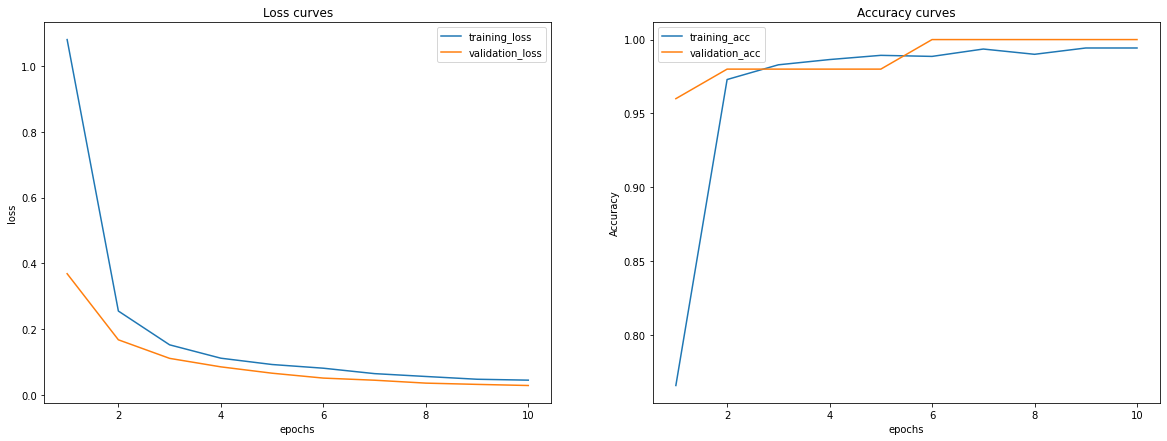

In [8]:
def plot_loss_curves(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1,len(history.history['loss'])+1)
    plt.figure(figsize = (20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label = "training_loss")
    plt.plot(epochs,val_loss,label = "validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label = "training_acc")
    plt.plot(epochs,val_accuracy,label = "validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plot_loss_curves(history_of_model)

In [9]:
model.evaluate(val_data_pf)

2/2 [==============================] - 0s 31ms/step - loss: 0.0277 - accuracy: 1.0000


[0.027662718668580055, 1.0]

# Predict

In [10]:
from keras.preprocessing import image
images = []
img_path = []
folder_path = 'image2test/'
for img in os.listdir(folder_path):
    img_path.append(img)
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size = (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    images.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
predict_x = model.predict(images)
classes_x = np.argmax(predict_x, axis = 1)
classes_x

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9])

In [11]:
result = dict(zip(img_path, classes_x))
print(result)

{'4.jpg': 0, '2.jpg': 0, '1.jpg': 0, '5.jpg': 0, '3.jpg': 0, '1 (1).jpg': 1, '3 (1).jpg': 1, '4 (1).jpg': 1, '2 (1).jpg': 1, '5 (1).jpg': 1, '1 (2).jpg': 2, '3 (2).jpg': 2, '5 (2).jpg': 2, '4 (2).jpg': 2, '2 (2).jpg': 2, '4 (3).jpg': 3, '3 (3).jpg': 3, '2 (3).jpg': 3, '1 (3).jpg': 3, '5 (3).jpg': 3, '3 (4).jpg': 4, '1 (4).jpg': 4, '2 (4).jpg': 4, '4 (4).jpg': 4, '5 (4).jpg': 4, '4 (5).jpg': 5, '5 (5).jpg': 5, '3 (5).jpg': 5, '2 (5).jpg': 5, '1 (5).jpg': 5, '1 (6).jpg': 6, '2 (6).jpg': 6, '5 (6).jpg': 6, '3 (6).jpg': 6, '4 (6).jpg': 6, '3 (7).jpg': 7, '2 (7).jpg': 7, '5 (7).jpg': 7, '1 (7).jpg': 7, '4 (7).jpg': 7, '5 (8).jpg': 8, '1 (8).jpg': 8, '2 (8).jpg': 8, '4 (8).jpg': 8, '3 (8).jpg': 8, '4 (9).jpg': 9, '2 (9).jpg': 9, '3 (9).jpg': 9, '5 (9).jpg': 9, '1 (9).jpg': 9}


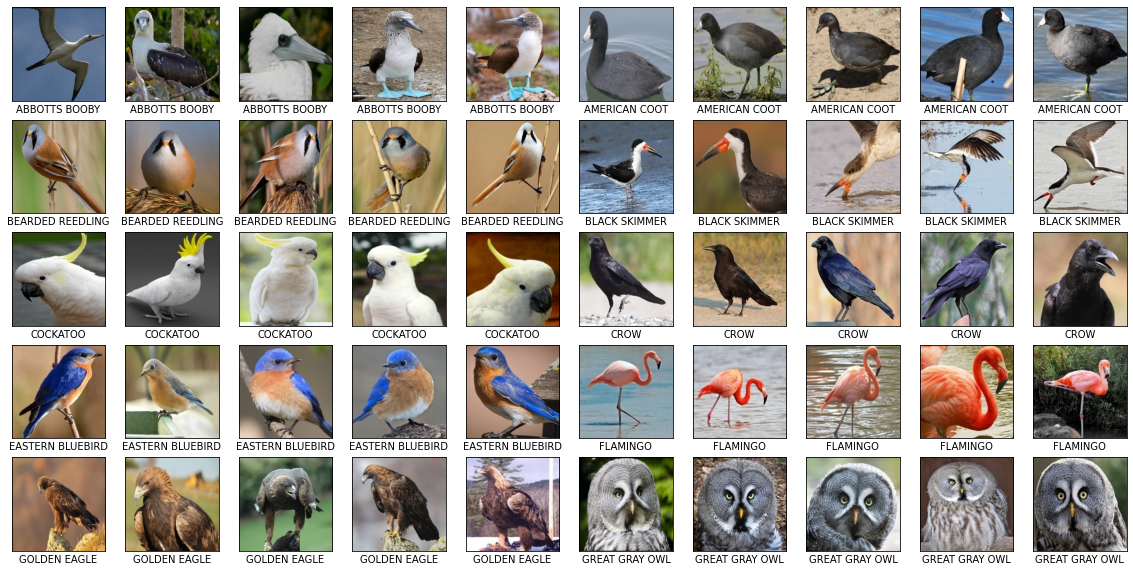

In [12]:
plt.figure(figsize = (20,10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_arr = cv2.imread('image2test/' + img_path[i])
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_arr)
    plt.xlabel(classes[classes_x[i]])
plt.show()

In [13]:
# sys.stdout = temp
# f.close()